In [2]:
# Libraries, parameters

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
from scipy.interpolate import interp1d, interpn, RegularGridInterpolator
from scipy.signal import fftconvolve
from scipy.stats import poisson
from scipy.optimize import minimize
import math

# Norms for the PMNS matrix squared:
u_e = [0, 0.674743, 0.302844, 0.0224125]
u_m = [0, 0.0946105, 0.360415, 0.544974]
u_t = [0, 0.230646, 0.33674,  0.432613]


# Conversion factor to go from kpc to 1/eV
conv_factor = 3.086e19 * 5.06773093741 * 1e6

# Conversion factor to go from kpc to m
kpctom = 3.086e19
kpctocm = 3.086e22

# More parameters:
phi0 = 100 # TeV^-1 cm^-2 s^-1, completely random, will be able to calculate this directly I think
e0 = 1 # TeV
index = 2.0 # Completely random, not sure how to calculate this exactly
width = 0.1 # In log10 scale, for cascade-like events, this is being not generous

# del_m2
dm2s = (0, 0, 0)

base = 10

In [3]:
# Download effective area

eff_a = pd.read_csv('EffA_GC_approx.csv').values

In [4]:
"""
Pseudo code steps:

1. Define functions for
    - probability of cascade like event (E, r, del_m2)
    - Effective area (E, theta)
    - Flux (hopefully given) (E, r, theta)
2. Smear over energy (know how to do this [hopefully] already)
3. Smear over angle (I don't know if the ordering of 2 and 3 matters all that much)
    - Actually might be able to do this first, just shove the initial neutrino map into the healpix smoothing fcn
    - Or maybe it would need to be last if we need maps collapsed on distance...
4. Integrate over distance from Earth

"""


"\nPseudo code steps:\n\n1. Define functions for\n    - probability of cascade like event (E, r, del_m2)\n    - Effective area (E, theta)\n    - Flux (hopefully given) (E, r, theta)\n2. Smear over energy (know how to do this [hopefully] already)\n3. Smear over angle (I don't know if the ordering of 2 and 3 matters all that much)\n    - Actually might be able to do this first, just shove the initial neutrino map into the healpix smoothing fcn\n    - Or maybe it would need to be last if we need maps collapsed on distance...\n4. Integrate over distance from Earth\n\n"

In [239]:
# Download the model:

# First index is the particle, second index is the attribute
# Important ones:
# [3]: neutrino particle ID. 12–electron neutrino, 14–muon neutrino, negative numbers are antiparticles
# [4]: neutrino energy [1e-09 EeV]
# [23], [24], [25]: created particle position, X, Y, Z resp. [kpc]

model_0 = np.loadtxt("first_GC_model.txt", comments="#", unpack=False)
model_1 = np.loadtxt("second_GC_model.txt", comments="#", unpack=False)

In [240]:
# Getting the data

num_nu = int(model_1.size/30)
X = np.zeros((num_nu))
Y = np.zeros((num_nu))
Z = np.zeros((num_nu))
E = np.zeros((num_nu))
Ecreate = np.zeros((num_nu))
Esource = np.zeros((num_nu))
for i in range(num_nu):
    X[i] = model_1[i][23]
    Y[i] = model_1[i][24]
    Z[i] = model_1[i][25]
    E[i] = np.log10(model_1[i][4])
    Ecreate[i] = np.log10(model_1[i][22])
    Esource[i] = np.log10(model_1[i][13])



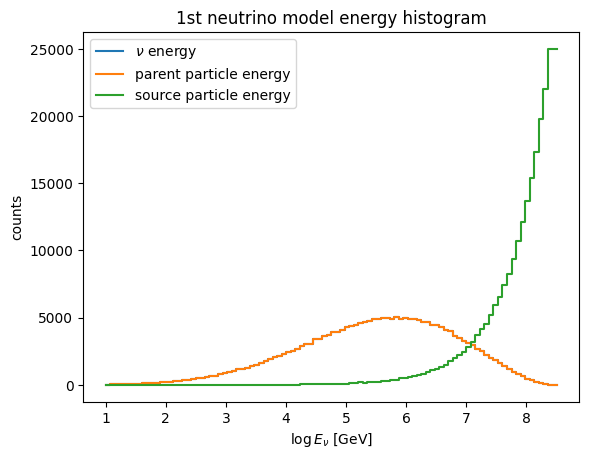

In [241]:
# E in log scale rn
nbins = 100
energies, e_bins = np.histogram(E, nbins)
energies_create, e_bins_create = np.histogram(Ecreate, nbins)
energies_source, e_bins_source = np.histogram(Esource, nbins)
bins_graph = np.delete(e_bins, nbins-1)
fig, ax = plt.subplots()
energy, = ax.step(bins_graph, energies)
energy_create, = ax.step(bins_graph, energies_create)
energy_source, = ax.step(bins_graph, energies_source)
# ax.fill_between(bins_graph, energies, 0, color='blue', alpha=.5, step='pre')
ax.set_xlabel(r"$\log E_{\nu}$ [GeV]")
ax.set_ylabel(r"counts")
ax.set_title("1st neutrino model energy histogram")
ax.legend([energy, energy_create, energy_source], [r"$\nu$ energy", r"parent particle energy", r"source particle energy"])

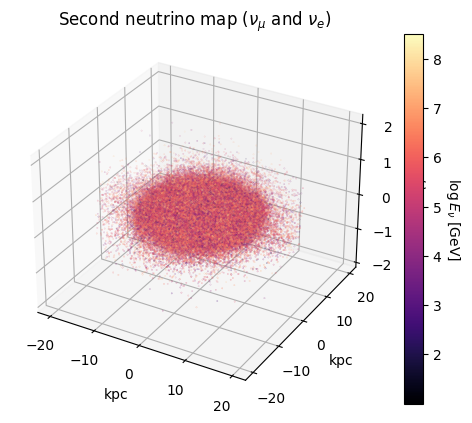

In [7]:
# Printing the data

ax = plt.axes(projection='3d')
# ax.scatter3D(0, 0, 0, s=100)
# ax.scatter3D(8, 0, 0, s=100)
map = ax.scatter3D(X, Y, Z, s=0.02, c=E, cmap='magma')
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_zlabel('kpc')
ax.set_title(r'Second neutrino map ($\nu_{\mu}$ and $\nu_{e}$)')
cbar = plt.colorbar(map)
cbar.set_label(r'$\log E_{\nu}$ [GeV]', rotation=270, labelpad = 15)

In [17]:
# Histogramming in 3D

positions = np.zeros((num_nu, 3))
for nu in range(num_nu):
    positions[nu][0] = model_1[nu][23]
    positions[nu][1] = model_1[nu][24]
    positions[nu][2] = model_1[nu][25]

bin_size=0.3
num_xbins, num_ybins, num_zbins = int(60/bin_size), int(60/bin_size), int(30/bin_size)
H, edges = np.histogramdd(positions, bins=(num_xbins, num_ybins, num_zbins), range=[(-30, 30), (-30, 30), (-3, 3)])

prob_dens_dist = np.divide(H, num_nu*(bin_size**2)*(bin_size/5))

In [9]:
# Printing the histogrammed data

# Printing 3D histogrammed data (looks pretty boring everything's hidden)

x_axes = np.zeros((edges[0].size))
y_axes = np.zeros((edges[1].size))
z_axes = np.zeros((edges[2].size))
# hist_dist = np.zeros((x_axes.size*y_axes.size*z_axes.size, 4))
hist_dist = []
for x in range(x_axes.size-1):
    for y in range(y_axes.size-1):
        for z in range(z_axes.size-1):
            array = [edges[0][x], edges[1][y], edges[2][z], prob_dens_dist[x][y][z]]
            # hist_dist[x+y+z][0] = edges[0][x]
            # hist_dist[x+y+z][1] = edges[1][y]
            # hist_dist[x+y+z][2] = edges[2][z]
            # hist_dist[x+y+z][3] = H[x][y][z]
            hist_dist.append(array)

X = np.zeros(len(hist_dist))
Y = np.zeros(len(hist_dist))
Z = np.zeros(len(hist_dist))
N = np.zeros(len(hist_dist))
for i in range(len(hist_dist)):
    X[i] = hist_dist[i][0]
    Y[i] = hist_dist[i][1]
    Z[i] = hist_dist[i][2]
    N[i] = hist_dist[i][3]

ax = plt.axes(projection='3d')
# ax.scatter3D(0, 0, 0, s=100)
# ax.scatter3D(8, 0, 0, s=100)
map = ax.scatter3D(X, Y, Z, s=1, c=N, cmap='Blues', alpha=0.3)
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_zlabel('kpc')
ax.set_title(r'First neutrino map ($\nu_{\mu}$ and $\nu_{e}$)')
cbar = plt.colorbar(map)
cbar.set_label(r'$\log E_{\nu}$ [GeV]', rotation=270, labelpad = 15)

Error in callback <function flush_figures at 0x11db6c860> (for post_execute):


KeyboardInterrupt: 

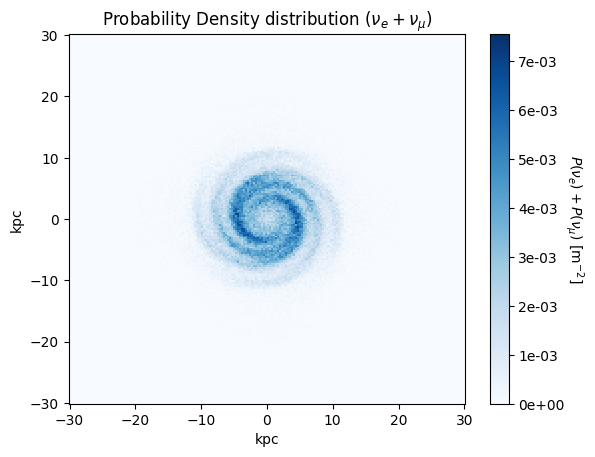

In [10]:
# Histogramming while flattening over z:
bin_size=0.3
num_xbins, num_ybins, num_zbins = int(60/bin_size), int(60/bin_size), int(1)
H, edges = np.histogramdd(positions, bins=(num_xbins, num_ybins, num_zbins), range=[(-30, 30), (-30, 30), (-3, 3)])
prob_dens_dist = np.divide(H, num_nu*(bin_size**2))

X = np.linspace(-30, 30, num_xbins)
Y = np.linspace(-30, 30, num_ybins)
zz = np.zeros((num_xbins, num_ybins))
for x in range(num_xbins):
    for y in range(num_ybins):
        zz[x][y] = prob_dens_dist[x][y][0]

h = plt.pcolormesh(X, Y, zz, shading='auto', cmap='Blues')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title(r'Probability Density distribution ($\nu_e + \nu_{\mu})$')
cbar = plt.colorbar(h, anchor=(0.0, 0.5), format='%.0e')
cbar.set_label(r'$P(\nu_e) + P(\nu_{\mu})$ [m$^{-2}$]', rotation=270, labelpad = 15)

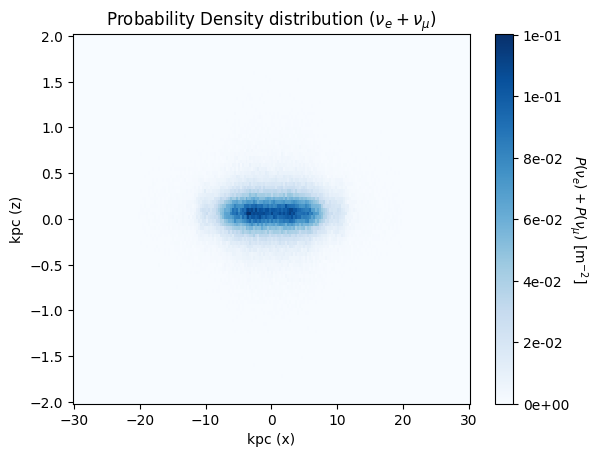

In [11]:
# Histogramming while flattening over y:
bin_size=0.3
num_xbins, num_ybins, num_zbins = int(60/bin_size), int(1), int(30/bin_size)
H, edges = np.histogramdd(positions, bins=(num_xbins, num_ybins, num_zbins), range=[(-30, 30), (-30, 30), (-2, 2)])
prob_dens_dist = np.divide(H, num_nu*(bin_size*(bin_size/5)))

X = np.linspace(-30, 30, num_xbins)
Z = np.linspace(-2, 2, num_zbins)
zz = np.zeros((num_zbins, num_xbins))
for x in range(num_xbins):
    for z in range(num_zbins):
        zz[z][x] = prob_dens_dist[x][0][z]

h = plt.pcolormesh(X, Z, zz, shading='auto', cmap='Blues')
plt.xlabel('kpc (x)')
plt.ylabel('kpc (z)')
plt.title(r'Probability Density distribution ($\nu_e + \nu_{\mu})$')
cbar = plt.colorbar(h, anchor=(0.0, 0.5), format='%.0e')
cbar.set_label(r'$P(\nu_e) + P(\nu_{\mu})$ [m$^{-2}$]', rotation=270, labelpad = 15)

In [18]:
# Interpolating the 3D probability density function

x = np.linspace(-30, 30, num_xbins)
y = np.linspace(-30, 30, num_ybins)
z = np.linspace(-3, 3, num_zbins)

# grid = np.meshgrid(x, y, z)

interp = RegularGridInterpolator((x, y, z), prob_dens_dist, method='linear')



In [19]:
print(interp([0, 0, 0]))

[0.00359256]


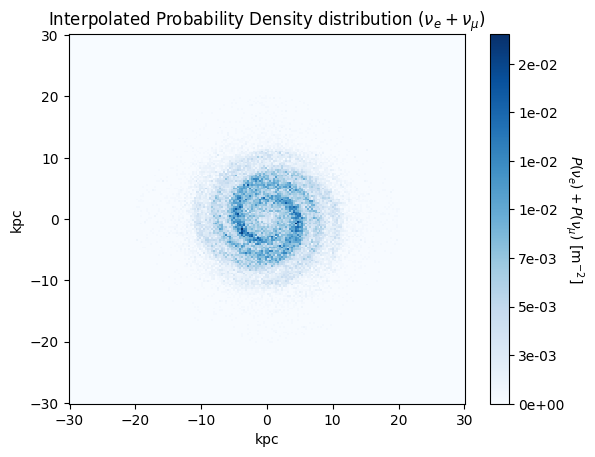

In [20]:
# Printing interpolated function

xbins, ybins = 200, 200
X = np.linspace(-30, 30, xbins)
Y = np.linspace(-30, 30, ybins)
zz = np.zeros((xbins, ybins))
for x in range(xbins):
    for y in range(ybins):
        zz[x][y] = interp([X[x], Y[y], 0])

h = plt.pcolormesh(X, Y, zz, shading='auto', cmap='Blues')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title(r'Interpolated Probability Density distribution ($\nu_e + \nu_{\mu})$')
cbar = plt.colorbar(h, anchor=(0.0, 0.5), format='%.0e')
cbar.set_label(r'$P(\nu_e) + P(\nu_{\mu})$ [m$^{-2}$]', rotation=270, labelpad = 15)

In [21]:
# l_eff per particle, in kpc:

def Leff(x, y, z):
    return np.sqrt((8-x)**2 + y**2 + z**2)

In [175]:
# Oscillation probability: Prob of oscillating into an electron neutrino (still assuming 1:2:0 flavor dist at source)
# Energy in TeV

def OscProb(dm2s, e_true, l_eff):

    l_eff = l_eff*conv_factor

    osc1 = (np.cos((dm2s[0] * l_eff)/(4*e_true*1e12)))**2
    osc2 = (np.cos((dm2s[1] * l_eff)/(4*e_true*1e12)))**2
    osc3 = (np.cos((dm2s[2] * l_eff)/(4*e_true*1e12)))**2

    prob_surv = osc1*(u_e[1]*u_e[1]) + osc2*(u_e[2]*u_e[2]) + osc3*(u_e[3]*u_e[3])
    prob_mue = osc1*(u_e[1]*u_m[1]) + osc2*(u_e[2]*u_m[2]) + osc3*(u_e[3]*u_m[3])
    prob_e = 0.666666*prob_mue + 0.333333*prob_surv 

    return prob_e


# Effective Area [cm^2]

x, y = [], []
for i in range(len(eff_a)):
    x.append(eff_a[i][0])
    y.append(eff_a[i][1])
f = interp1d(x, y)

def EffA(e_true):
    effa = 10000*f(e_true)
    return effa


# Flux function [kpc^-3]:

def Flux(e_true, x, y, z):
    if (np.abs(x) <=30 and np.abs(y) <= 30 and np.abs(z) <= 3):
        return (interp([x, y, z]))*phi0*(e_true/e0)**(-index)
    else:
        return 0

flux = np.vectorize(Flux, excluded=['x', 'y', 'z'])


#Galactic coords to (x, y, z) centered at the galactic center

def Cartesian(r, l, b):
    # r, l, b = coords[0], coords[1], coords[2]
    x = 8 - r*np.cos(l)*np.cos(b)
    y = r*np.sin(l)*np.cos(b)
    z = r*np.sin(b)
    return [x, y, z]

cartesian = np.frompyfunc(Cartesian, 3, 1)

In [216]:
test = cartesian(1, np.pi, 0)
print(test)

[9.0, 1.2246467991473532e-16, 0.0]


Text(0.5, 1.0, '$\\delta m^2 = 10^{-14.0}$ eV$^2$, $L_{eff} = 4$ kpc')

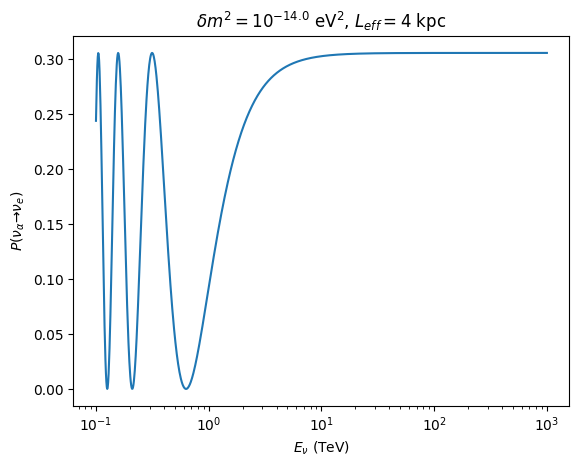

In [23]:
# Plotting oscillation probs:

dm2 = 10**(-14.5)
dm2s = (dm2, dm2, dm2)
length = 8

def OscProb1(e_true):
    return OscProb(dm2s, e_true, length)
oscprob = np.frompyfunc(OscProb1, 1, 1)

a = np.logspace(-1, 3, 1000)
probs = oscprob(a)
# probs = []
# for i in range(len(a)):
#     probs.append(OscProb(dm2s, a[i], length))

fig, ax = plt.subplots()
array = ax.plot(a, probs)
ax.set_xscale('log')
ax.set_xticks([10**(-1), 10**0, 10**1, 10**2, 10**3])
ax.set_xlabel(r"$E_{\nu}$ (TeV)")
ax.set_ylabel(r"$P(\nu_{\alpha} \to \nu_{e})$")
ax.set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$, $L_{eff} = 4$ kpc")


In [46]:
e_true = 1
delm2 = 10**(-14.5)
delm2s = (delm2, delm2, delm2)

num_xbins = 200
num_ybins = 200

X = np.linspace(-20, 20, num_xbins)
Y = np.linspace(-20, 20, num_ybins)
zz = np.zeros((num_xbins, num_ybins))
for i, xval in enumerate(X):
    for j, yval in enumerate(Y):
        l_eff = ((yval-8)**2 + xval**2)**0.5
        oscprob = OscProb(delm2s, e_true, l_eff)
        zz[i][j] = Flux(e_true, xval, yval, 0)*oscprob

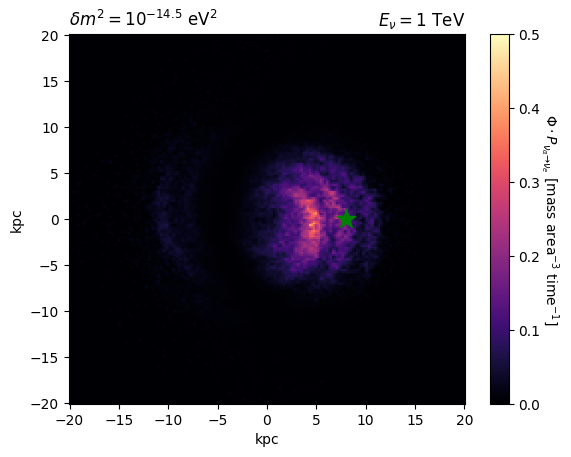

In [47]:
h = plt.pcolormesh(X, Y, zz, shading='auto', cmap='magma', vmin=0, vmax=0.5)
plt.scatter(8, 0, s=200, c='Green', marker='*')

plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title(r'$\delta m^2 = 10^{-14.5}$ eV$^2$', loc='left')
plt.title(r'$E_{\nu} = 1$ TeV', loc='right')
cbar = plt.colorbar(h, anchor=(0.0, 0.1))
#, format='%.0e'
cbar.set_label(r'$\Phi \cdot P_{\nu_{\alpha} \to \nu_{e}}$ [mass area$^{-3}$ time$^{-1}$]', rotation=270, labelpad = 15)

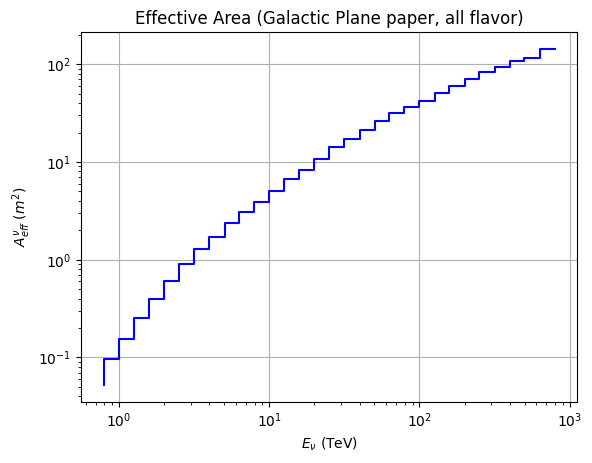

In [48]:
# Plotting Effective Area
x, y = [], []
for i in range(len(eff_a)):
    x.append(eff_a[i][0])
    y.append(eff_a[i][1])

fig, ax = plt.subplots()
plot1 = ax.step(x, y, c='blue')
ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$E_{\nu}$ (TeV)")
ax.set_ylabel(r"$A_{eff}^{\nu}$ ($m^2$)")
ax.set_title(r"Effective Area (Galactic Plane paper, all flavor)")
plt.show()

In [178]:
# Perfect detector event distribution function as a fcn of line of sight angle

# LOS length limits in kpc
r0 = 0
r_max = 30
bin_length = 0.5
r_bins = np.arange(0, r_max, bin_length)
numbins = int(r_max/bin_length)

def EventDist(dm2s, e_true, l, b):

    ls, bs = np.full(numbins, l), np.full(numbins, b)

    # want to create two arrays of shape (numbins, 3)
    bins_gal = np.column_stack((r_bins, ls, bs))
    bins_cart = cartesian(r_bins, ls, bs)

    events = np.zeros((numbins))
    for i, element in enumerate(events):
        flux = Flux(e_true, bins_cart[i][0], bins_cart[i][1], bins_cart[i][2])*bin_length
        probe = OscProb(dm2s, e_true, bins_gal[i][0])
        events[i] = flux*probe*EffA(e_true)

    return np.sum(events)


In [186]:
# 0.8, 791 TeV 
num_bins = 100
ebins = np.logspace(np.log10(0.8), np.log10(791), num_bins)
def Array(dm2, l, b):
    dm2s = (dm2, dm2, dm2)
    array = np.zeros(num_bins)
    for i in range(num_bins):
        array[i] = EventDist(dm2s, ebins[i], l, b)
    return array


Text(1.0, 1.0, '$\\vec{\\Theta} = (0, 0)$')

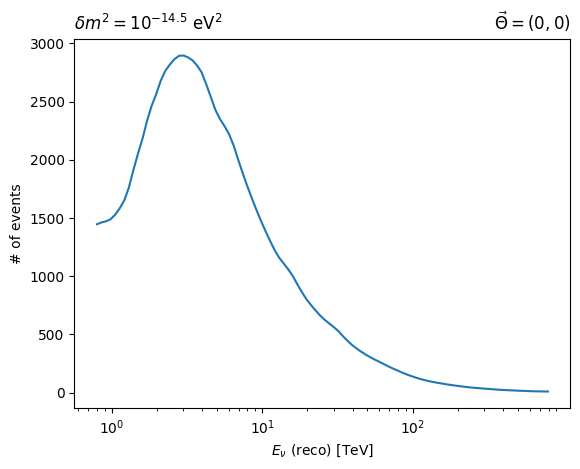

In [201]:
dm2 = 10**(-14.5)
l = 0
b = 0
fig, ax = plt.subplots()
GC = ax.plot(ebins, Array(dm2, l, b))
ax.set_xscale('log')
ax.set_xticks([10**0, 10**1, 10**2])
ax.set_xlabel(r"$E_{\nu}$ (reco) [TeV]")
ax.set_ylabel(r"# of events")
ax.set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
ax.set_title(r"$\vec{\Theta} = (0, 0)$", loc='right')

In [221]:
# Different LOS and PD scenarios

l1 = 0
l2 = np.pi/8
l3 = -np.pi/8
l4 = np.pi/4
l5 = -np.pi/4

dm21 = 10**(-13.5)
dm22 = 10**(-14.0)
dm23 = 10**(-14.5)
dm24 = 10**(-15.0)

narray_l1 = Array(0, l1, 0)
aarray_l1_1 = Array(dm21, l1, 0)
aarray_l1_2 = Array(dm22, l1, 0)
aarray_l1_3 = Array(dm23, l1, 0)
aarray_l1_4 = Array(dm24, l1, 0)

narray_l2 = Array(0, l2, 0)
aarray_l2_1 = Array(dm21, l2, 0)
aarray_l2_2 = Array(dm22, l2, 0)
aarray_l2_3 = Array(dm23, l2, 0)
aarray_l2_4 = Array(dm24, l2, 0)

narray_l3 = Array(0, l3, 0)
aarray_l3_1 = Array(dm21, l3, 0)
aarray_l3_2 = Array(dm22, l3, 0)
aarray_l3_3 = Array(dm23, l3, 0)
aarray_l3_4 = Array(dm24, l3, 0)

narray_l4 = Array(0, l4, 0)
aarray_l4_1 = Array(dm21, l4, 0)
aarray_l4_2 = Array(dm22, l4, 0)
aarray_l4_3 = Array(dm23, l4, 0)
aarray_l4_4 = Array(dm24, l4, 0)

narray_l5 = Array(0, l5, 0)
aarray_l5_1 = Array(dm21, l5, 0)
aarray_l5_2 = Array(dm22, l5, 0)
aarray_l5_3 = Array(dm23, l5, 0)
aarray_l5_4 = Array(dm24, l5, 0)



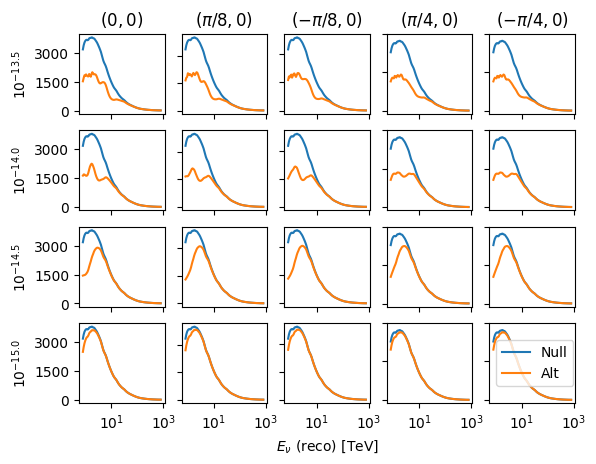

In [225]:
# Plotting these scenarios

fig, axs = plt.subplots(4, 5)

axs[0, 0].plot(ebins, narray_l1)
axs[0, 0].plot(ebins, aarray_l1_1)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yticks([0, 1500, 3000])
# axs[0, 0].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", loc="left")
axs[0, 0].set_ylabel(r"$10^{-13.5}$")
axs[0, 0].set_title(r"$(0, 0)$")

axs[1, 0].plot(ebins, narray_l1)
axs[1, 0].plot(ebins, aarray_l1_2)
axs[1, 0].set_xscale('log')
axs[1, 0].set_yticks([0, 1500, 3000])
axs[1, 0].set_ylabel(r"$10^{-14.0}$")
# axs[1, 0].set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$", loc="left")
# axs[1, 0].set_title(r"$\vec{\Theta} = (0, 0)$", loc='right')

axs[2, 0].plot(ebins, narray_l1)
axs[2, 0].plot(ebins, aarray_l1_3)
axs[2, 0].set_xscale('log')
axs[2, 0].set_yticks([0, 1500, 3000])
axs[2, 0].set_ylabel(r"$10^{-14.5}$")
# axs[2, 0].set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
# axs[2, 0].set_title(r"$\vec{\Theta} = (0, 0)$", loc='right')

axs[3, 0].plot(ebins, narray_l1)
axs[3, 0].plot(ebins, aarray_l1_4)
axs[3, 0].set_xscale('log')
axs[3, 0].set_yticks([0, 1500, 3000])
axs[3, 0].set_ylabel(r"$10^{-15.0}$")
# axs[3, 0].set_title(r"$\delta m^2 = 10^{-15.0}$ eV$^2$", loc="left")
# axs[3, 0].set_title(r"$\vec{\Theta} = (0, 0)$", loc='right')



axs[0, 1].plot(ebins, narray_l2)
axs[0, 1].plot(ebins, aarray_l2_1)
axs[0, 1].set_xscale('log')
axs[0, 1].set_yticks([0, 1500, 3000])
# axs[0, 1].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", loc="left")
axs[0, 1].set_title(r"$(\pi/8, 0)$")

axs[1, 1].plot(ebins, narray_l2)
axs[1, 1].plot(ebins, aarray_l2_2)
axs[1, 1].set_xscale('log')
axs[1, 1].set_yticks([0, 1500, 3000])
# axs[1, 1].set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$", loc="left")
# axs[1, 1].set_title(r"$\vec{\Theta} = (\pi/4, 0)$", loc='right')

axs[2, 1].plot(ebins, narray_l2)
axs[2, 1].plot(ebins, aarray_l2_3)
axs[2, 1].set_xscale('log')
axs[2, 1].set_yticks([0, 1500, 3000])
# axs[2, 1].set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
# axs[2, 1].set_title(r"$\vec{\Theta} = (\pi/4, 0)$", loc='right')

axs[3, 1].plot(ebins, narray_l2)
axs[3, 1].plot(ebins, aarray_l2_4)
axs[3, 1].set_xscale('log')
axs[3, 1].set_yticks([0, 1500, 3000])
# axs[3, 1].set_title(r"$\delta m^2 = 10^{-15.0}$ eV$^2$", loc="left")
# axs[3, 1].set_title(r"$\vec{\Theta} = (\pi/4, 0)$", loc='right')



axs[0, 2].plot(ebins, narray_l3)
axs[0, 2].plot(ebins, aarray_l3_1)
axs[0, 2].set_xscale('log')
axs[0, 2].set_yticks([0, 1500, 3000])
# axs[0, 2].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", loc="left")
axs[0, 2].set_title(r"$(-\pi/8, 0)$")

axs[1, 2].plot(ebins, narray_l3)
axs[1, 2].plot(ebins, aarray_l3_2)
axs[1, 2].set_xscale('log')
axs[1, 2].set_yticks([0, 1500, 3000])
# axs[1, 2].set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$", loc="left")
# axs[1, 2].set_title(r"$\vec{\Theta} = (\pi/2, 0)$", loc='right')

axs[2, 2].plot(ebins, narray_l3)
axs[2, 2].plot(ebins, aarray_l3_3)
axs[2, 2].set_xscale('log')
axs[2, 2].set_yticks([0, 1500, 3000])
# axs[2, 2].set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
# axs[2, 2].set_title(r"$\vec{\Theta} = (\pi/2, 0)$", loc='right')

axs[3, 2].plot(ebins, narray_l3)
axs[3, 2].plot(ebins, aarray_l3_4)
axs[3, 2].set_xscale('log')
axs[3, 2].set_yticks([0, 1500, 3000])
# axs[3, 2].set_title(r"$\delta m^2 = 10^{-15.0}$ eV$^2$", loc="left")
# axs[3, 2].set_title(r"$\vec{\Theta} = (\pi/2, 0)$", loc='right')
axs[3, 2].set_xlabel(r"$E_{\nu}$ (reco) [TeV]")



axs[0, 3].plot(ebins, narray_l4)
axs[0, 3].plot(ebins, aarray_l4_1)
axs[0, 3].set_xscale('log')
axs[0, 3].set_yticks([0, 1500, 3000])
# axs[0, 3].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", loc="left")
axs[0, 3].set_title(r"$(\pi/4, 0)$")
# axs[0, 3].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", rotation=-90, position=(1, 0.5), ha='left', va='center')

axs[1, 3].plot(ebins, narray_l4)
axs[1, 3].plot(ebins, aarray_l4_2)
axs[1, 3].set_xscale('log')
axs[1, 3].set_yticks([0, 1500, 3000])
# axs[1, 3].set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$", loc="left")
# axs[1, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')

axs[2, 3].plot(ebins, narray_l4)
axs[2, 3].plot(ebins, aarray_l4_3)
axs[2, 3].set_xscale('log')
axs[2, 3].set_yticks([0, 1500, 3000])
# axs[2, 3].set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
# axs[2, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')

axs[3, 3].plot(ebins, narray_l4)
axs[3, 3].plot(ebins, aarray_l4_4)
axs[3, 3].set_xscale('log')
axs[3, 3].set_yticks([0, 1500, 3000])
# axs[3, 3].set_title(r"$\delta m^2 = 10^{-15.0}$ eV$^2$", loc="left")
# axs[3, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')



axs[0, 4].plot(ebins, narray_l4)
axs[0, 4].plot(ebins, aarray_l4_1)
axs[0, 4].set_xscale('log')
axs[0, 4].set_yticks([0, 1500, 3000])
# axs[0, 3].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", loc="left")
axs[0, 4].set_title(r"$(-\pi/4, 0)$")
# axs[0, 3].set_title(r"$\delta m^2 = 10^{-13.5}$ eV$^2$", rotation=-90, position=(1, 0.5), ha='left', va='center')

axs[1, 4].plot(ebins, narray_l4)
axs[1, 4].plot(ebins, aarray_l4_2)
axs[1, 4].set_xscale('log')
axs[1, 4].set_yticks([0, 1500, 3000])
# axs[1, 3].set_title(r"$\delta m^2 = 10^{-14.0}$ eV$^2$", loc="left")
# axs[1, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')

axs[2, 4].plot(ebins, narray_l4)
axs[2, 4].plot(ebins, aarray_l4_3)
axs[2, 4].set_xscale('log')
axs[2, 4].set_yticks([0, 1500, 3000])
# axs[2, 3].set_title(r"$\delta m^2 = 10^{-14.5}$ eV$^2$", loc="left")
# axs[2, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')

null, = axs[3, 4].plot(ebins, narray_l4)
alt, = axs[3, 4].plot(ebins, aarray_l4_4)
axs[3, 4].set_xscale('log')
axs[3, 4].set_yticks([0, 1500, 3000])
# axs[3, 3].set_title(r"$\delta m^2 = 10^{-15.0}$ eV$^2$", loc="left")
# axs[3, 3].set_title(r"$\vec{\Theta} = (3\pi/4, 0)$", loc='right')
axs[3, 4].legend([null, alt], [r"Null", r"Alt"])


for ax in axs.flat:
    ax.label_outer()

In [193]:
# Reco energy smearing:

# LOS length limits in kpc
r0 = 0
r_max = 30
bin_length = 0.5
r_bins = np.arange(0, r_max, bin_length)
numbins = int(r_max/bin_length)

def EventDist(dm2s, e_true, l, b):

    ls, bs = np.full(numbins, l), np.full(numbins, b)

    # want to create two arrays of shape (numbins, 3)
    bins_gal = np.column_stack((r_bins, ls, bs))
    bins_cart = cartesian(r_bins, ls, bs)

    events = np.zeros((numbins))
    for i, element in enumerate(events):
        flux = Flux(e_true, bins_cart[i][0], bins_cart[i][1], bins_cart[i][2])*bin_length
        probe = OscProb(dm2s, e_true, bins_gal[i][0])
        events[i] = flux*probe*EffA(e_true)

    return np.sum(events)
